#### Hidden Markov Model Statistical Learning 

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
import logging
import itertools
import matplotlib.pyplot as plt

from pyhhmm.gaussian import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Supress warning in hmmlearn
warnings.filterwarnings("ignore")

# Change plot style to ggplot for better visualization
plt.style.use('ggplot')

#### Data Acquisition and Initial Observation

In [2]:
class FuturesProduct():
    def __init__(self, symbol, start_date, end_date):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.get_data()
        self.log_returns()
    
    def get_data(self):
        futures = yf.download(self.symbol, self.start_date, self.end_date)
        futures.rename(columns = {"Close" : "price"}, inplace = True)
        self.data = futures
        return futures
    
    def log_returns(self):
        self.data["log_returns"] = np.log(self.data.price / self.data.price.shift(1))
        
    def plot_prices(self):
        self.data["Close"].plot(figsize = (20,8), color = "blue")
        plt.title("Price Chart: {}".format(self.symbol), fontsize = 15)
        
    def plot_returns(self, kind = "ts"):
        if kind == "ts":
            self.data.log_returns.plot(figsize = (20,8))
            plt.title("Returns: {}").format(self.symbol, fontsize = 15)
        elif kind == "hist":
            self.data.log_returns.hist(figsize = (20,8), bins = int(np.sqrt(len(self.data))))
            plt.title("Return frequency: {}".format(self.symbol), fontsize = 15)
        

#### Data Acquisition

In [3]:
ng = FuturesProduct("NG=F", "2017-01-01", "2024-12-31")

[*********************100%***********************]  1 of 1 completed


In [4]:
ng.get_data()

[*********************100%***********************]  1 of 1 completed


Price,price,High,Low,Open,Volume
Ticker,NG=F,NG=F,NG=F,NG=F,NG=F
Date,,,,,
2017-01-03,3.327,3.568,3.267,3.568,254134
2017-01-04,3.267,3.358,3.236,3.317,171528
2017-01-05,3.273,3.346,3.172,3.260,208432
2017-01-06,3.285,3.358,3.214,3.304,140075
2017-01-09,3.103,3.275,3.098,3.253,163393
...,...,...,...,...,...
2024-12-23,3.656,3.944,3.581,3.869,125622
2024-12-24,3.946,3.958,3.666,3.695,66852


#### Initial Observation

In [5]:
ng.log_returns()

<Axes: xlabel='Date'>

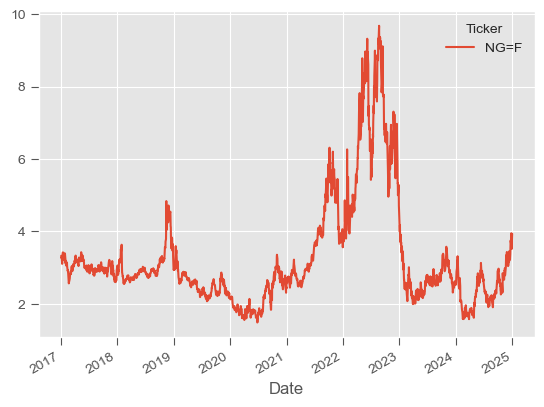

In [6]:
ng.data.price.plot()

<Axes: xlabel='Date'>

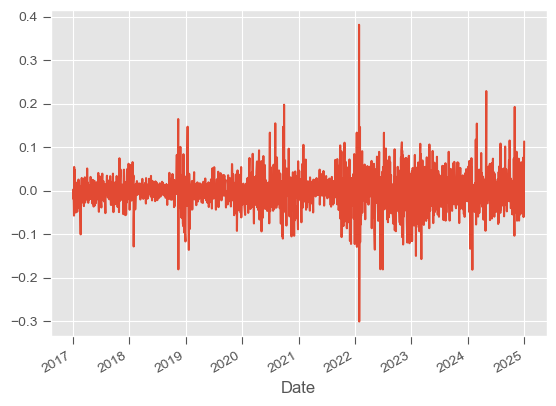

In [7]:
ng.data.log_returns.plot()

<Axes: >

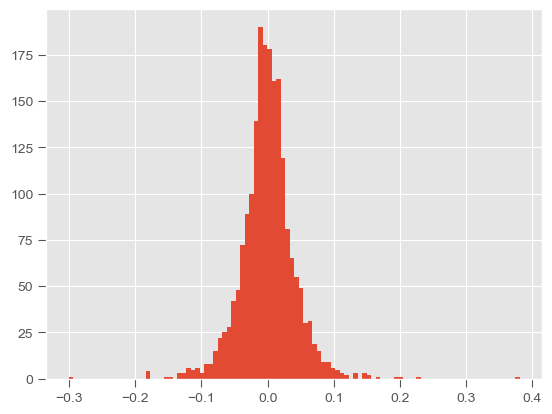

In [8]:
ng.data.log_returns.hist(bins = 100)

#### Data Acquisition for Hidden Market modeling

In [9]:
start_date = "2024-01-01"
end_date = "2024-12-31"
symbol = "NG=F"
futures = yf.download(symbol, start_date, end_date)
df = futures.copy()

[*********************100%***********************]  1 of 1 completed


In [10]:
print("=== COLUMN STRUCTURE ===")
for c in df.columns:
    print(c, type(c))

print("\n=== COLUMN LEVELS ===")
if hasattr(df.columns, "levels"):
    for i, lvl in enumerate(df.columns.levels):
        print(f"Level {i}:", list(lvl))

print("\n=== SAMPLE DATA ===")
print(df.head())
print(df.tail())
print("Shape:", df.shape)


=== COLUMN STRUCTURE ===
('Close', 'NG=F') <class 'tuple'>
('High', 'NG=F') <class 'tuple'>
('Low', 'NG=F') <class 'tuple'>
('Open', 'NG=F') <class 'tuple'>
('Volume', 'NG=F') <class 'tuple'>

=== COLUMN LEVELS ===
Level 0: ['Close', 'High', 'Low', 'Open', 'Volume']
Level 1: ['NG=F']

=== SAMPLE DATA ===
Price       Close   High    Low   Open  Volume
Ticker       NG=F   NG=F   NG=F   NG=F    NG=F
Date                                          
2024-01-02  2.568  2.675  2.524  2.605  132454
2024-01-03  2.668  2.719  2.537  2.575  166472
2024-01-04  2.821  2.863  2.681  2.688  206311
2024-01-05  2.893  2.906  2.681  2.845  187503
2024-01-08  2.980  3.012  2.694  2.950  237672
Price       Close   High    Low   Open  Volume
Ticker       NG=F   NG=F   NG=F   NG=F    NG=F
Date                                          
2024-12-23  3.656  3.944  3.581  3.869  125622
2024-12-24  3.946  3.958  3.666  3.695   66852
2024-12-26  3.715  4.010  3.652  3.970   67209
2024-12-27  3.514  3.887  3.370  3.7

In [11]:
# --- Normalize MultiIndex columns if needed ---
if isinstance(df.columns, pd.MultiIndex):
    # Option A: flatten to second level if OHLC is always level 1
    if "Close" in df.columns.get_level_values(1):
        df = df.copy()
        df.columns = df.columns.get_level_values(1)
    else:
        # Option B: try to auto-detect OHLC level
        for lvl in range(df.columns.nlevels):
            if {"Close", "High", "Low"}.issubset(df.columns.get_level_values(lvl)):
                df = df.copy()
                df.columns = df.columns.get_level_values(lvl)
                break

# --- Verify required columns exist ---
required = {"Close", "High", "Low"}
missing = required - set(df.columns)

if missing:
    raise ValueError(f"Missing required OHLC columns: {missing}")


In [12]:
df = df.sort_index()  # ensure clean index

df["Returns"] = df["Close"].pct_change()
df["Volatility"] = (df["High"] / df["Low"]) - 1

# Drop only rows where these features are NaN
df = df.dropna(subset=["Returns", "Volatility"])


In [13]:
print("NaNs in Returns:", df["Returns"].isna().sum())
print("NaNs in Volatility:", df["Volatility"].isna().sum())
print("Final shape:", df.shape)


NaNs in Returns: 0
NaNs in Volatility: 0
Final shape: (250, 7)


#### Feature Engineering

In [14]:
# Create features for evaluation

df["Returns"] = df["Close"].pct_change()
df["Volatility"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)


In [15]:
df

Price,Close,High,Low,Open,Volume,Returns,Volatility
Date,,,,,,,
2024-01-04,2.821,2.863,2.681,2.688,206311,0.057346,0.067885
2024-01-05,2.893,2.906,2.681,2.845,187503,0.025523,0.083924
2024-01-08,2.980,3.012,2.694,2.950,237672,0.030073,0.118040
2024-01-09,3.190,3.392,2.884,2.943,351780,0.070470,0.176144
2024-01-10,3.039,3.226,2.956,3.167,258013,-0.047335,0.091340
...,...,...,...,...,...,...,...
2024-12-23,3.656,3.944,3.581,3.869,125622,-0.024546,0.101368
2024-12-24,3.946,3.958,3.666,3.695,66852,0.079322,0.079651
2024-12-26,3.715,4.010,3.652,3.970,67209,-0.058540,0.098029


In [16]:
# Features for training
X_train = df[["Returns", "Volatility"]]
X_train.head()


Price,Returns,Volatility
Date,,
2024-01-04,0.057346,0.067885
2024-01-05,0.025523,0.083924
2024-01-08,0.030073,0.118040
2024-01-09,0.070470,0.176144
2024-01-10,-0.047335,0.091340


In [17]:
# Clean training data
X = X_train.copy()

# 1. Remove rows with NaN or Inf
X = X_train.replace([np.inf, -np.inf], np.nan)
X = X_train.dropna()

#### Hidden Markov Model Training

In [18]:
# Model Training
from hmmlearn.hmm import GaussianHMM

hmm_model = GaussianHMM(n_components=3, covariance_type="full")
hmm_model.fit(X_train.values)


,n_components,3
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,None


In [19]:
# Regime State preliminary observations
hidden_states = hmm_model.predict(X_train.values)
print(hidden_states[:40])
len(hidden_states)

[1 1 2 1 2 1 1 2 1 2 1 0 0 0 2 1 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 2 1 2
 1 0 0]


249

#### Hidden Markov Observations

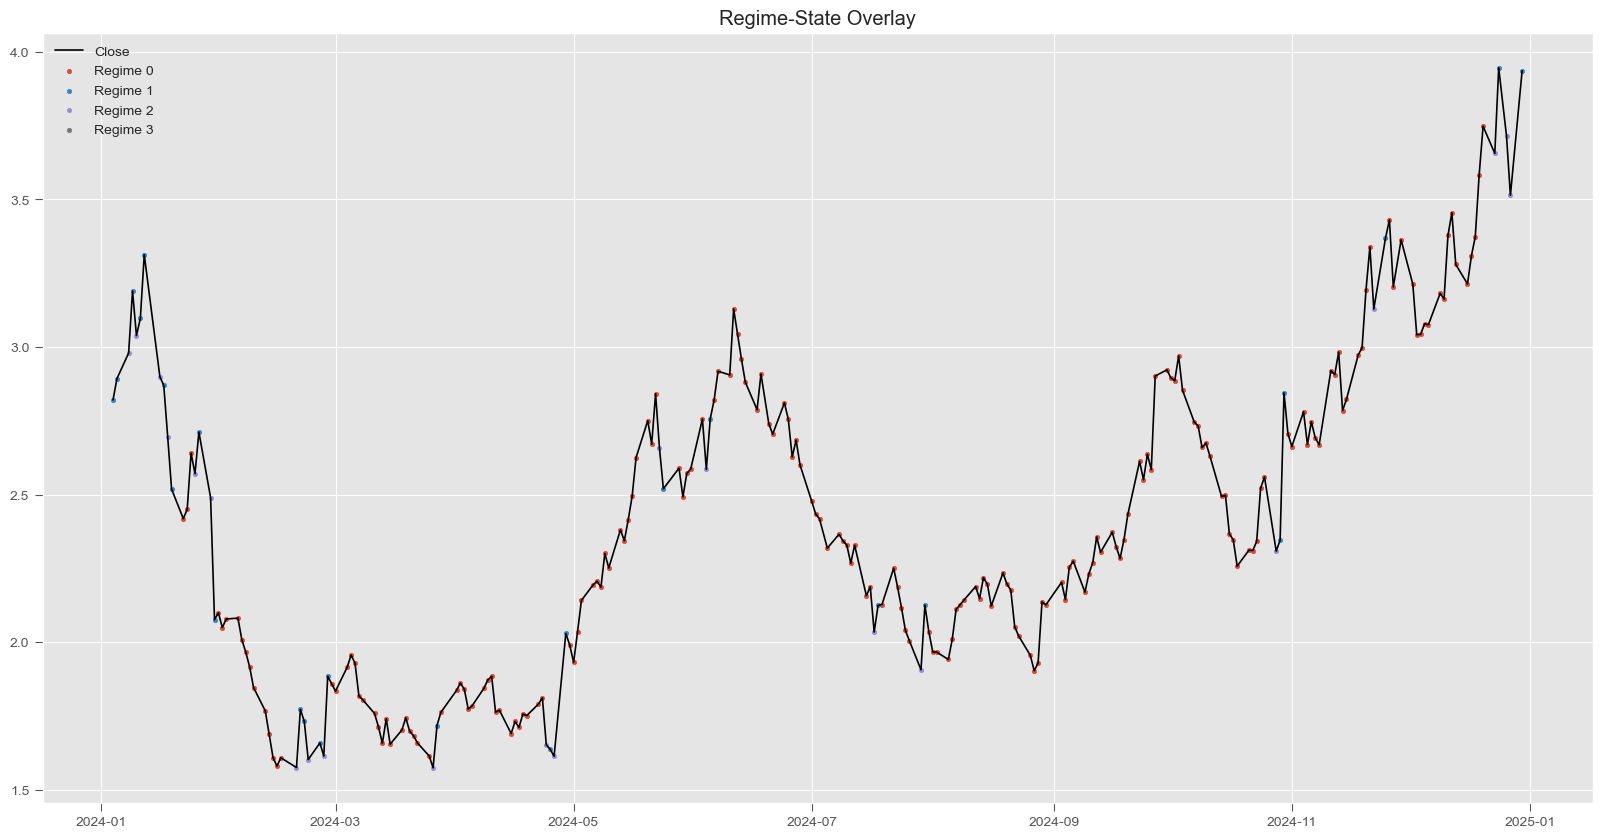

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Ensure df is sorted and aligned
# ---------------------------------------------------------
df = df.sort_index()

# Extract prices AFTER feature engineering and dropna
prices = df["Close"].values
feature_cols = ["Returns", "Volatility"]
states = hmm_model.predict(df[feature_cols].values)

# Hard alignment check
if len(prices) != len(states):
    raise ValueError(
        f"Length mismatch: prices={len(prices)}, states={len(states)}. "
        "Ensure states are predicted on the same filtered DataFrame."
    )

# ---------------------------------------------------------
# 2. Vectorized regime masks (no loops, no index errors)
# ---------------------------------------------------------
reg0 = np.where(states == 0, prices, np.nan)
reg1 = np.where(states == 1, prices, np.nan)
reg2 = np.where(states == 2, prices, np.nan)
reg3 = np.where(states == 3, prices, np.nan)

# ---------------------------------------------------------
# 3. Plotting
# ---------------------------------------------------------
plt.figure(figsize=(20, 10))
plt.plot(df.index, prices, color="black", linewidth=1.2, label="Close")

plt.scatter(df.index, reg0, s=10, label="Regime 0")
plt.scatter(df.index, reg1, s=10, label="Regime 1")
plt.scatter(df.index, reg2, s=10, label="Regime 2")
plt.scatter(df.index, reg3, s=10, label="Regime 3")

plt.title("Regime-State Overlay")
plt.legend()
plt.grid(True)
plt.show()
